In [52]:
import pandas as pd

# Load the merged dataset
data_path = '../data/merged/final_dataset.csv'
df = pd.read_csv(data_path)

# Display basic info
print(" Dataset Loaded")
df.head()

 Dataset Loaded


,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,datetime,...,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,5545,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,02-10-2012 09:00,2012-02-10 09:00:00,...,snow,-14.927778,-14.927778,0.90,4.3631,2.0,1.5939,0.0,1034.81,Foggy starting in the morning continuing until...
1,4516,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,02-10-2012 10:00,2012-02-10 10:00:00,...,snow,-13.888889,-19.050000,0.83,8.0500,330.0,1.9320,0.0,1035.20,Foggy starting in the morning continuing until...
2,4767,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,02-10-2012 11:00,2012-02-10 11:00:00,...,snow,-11.111111,-11.111111,0.73,4.8300,20.0,2.0930,0.0,1035.30,Foggy starting in the morning continuing until...
3,5026,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,02-10-2012 12:00,2012-02-10 12:00:00,...,snow,-11.161111,-15.916667,0.70,8.2110,352.0,2.0608,0.0,1035.06,Foggy starting in the morning continuing until...
4,4918,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,02-10-2012 13:00,2012-02-10 13:00:00,...,snow,-8.888889,-8.888889,0.56,1.6100,320.0,2.5760,0.0,1034.70,Foggy starting in the morning continuing until...


In [53]:
# Keep only relevant numeric columns
df = df[['datetime', 'traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',
         'Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
         'Wind Speed (km/h)', 'Pressure (millibars)']]

# Drop rows with missing values
df.dropna(inplace=True)

# Sort by datetime just in case
df['datetime'] = pd.to_datetime(df['datetime'])
df.sort_values('datetime', inplace=True)
df.reset_index(drop=True, inplace=True)

print(" Cleaned dataset:")
df.head()


 Cleaned dataset:


,datetime,traffic_volume,temp,rain_1h,snow_1h,clouds_all,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Pressure (millibars)
0,2012-01-11 00:00:00,716,271.73,0.0,0.0,1,1.183333,1.183333,0.96,3.1395,1029.55
1,2012-01-11 01:00:00,453,270.91,0.0,0.0,1,1.111111,1.111111,0.92,3.2200,1029.70
2,2012-01-11 02:00:00,324,270.15,0.0,0.0,1,1.111111,-0.894444,0.92,6.4400,1030.00
3,2012-01-11 03:00:00,390,269.68,0.0,0.0,1,1.738889,1.738889,0.93,3.1234,1030.02
4,2012-01-11 04:00:00,775,269.44,0.0,0.0,1,2.222222,2.222222,0.92,4.8300,1030.00


In [54]:
df['day_of_week'] = df['datetime'].dt.dayofweek  # Monday=0, Sunday=6
df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month

In [55]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns_to_scale = ['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',
                    'Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
                    'Wind Speed (km/h)', 'Pressure (millibars)']

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])


In [56]:
from sklearn.model_selection import train_test_split

# Split data into train and test (for example, 80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)


In [57]:
import numpy as np

# Convert data to numpy arrays
X_train = train_df[columns_to_scale].values
X_test = test_df[columns_to_scale].values

# Reshape data for LSTM input
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # 1 timestep
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))      # 1 timestep


In [58]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Initialize scaler
scaler = MinMaxScaler()

# Select features to scale
features = ['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 
            'Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 
            'Wind Speed (km/h)', 'Pressure (millibars)']

# Scale features
scaled_data = scaler.fit_transform(df[features])

# Function to create sequences of time steps
def create_sequences(data, time_steps):
    x, y = [], []
    for i in range(time_steps, len(data)):
        x.append(data[i-time_steps:i])
        y.append(data[i, 0])  # Predicting the traffic volume (1st column in features)
    return np.array(x), np.array(y)

# Define the time steps for the sequence (e.g., 10 hours)
time_steps = 10

# Create sequences
x, y = create_sequences(scaled_data, time_steps)


In [34]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

# Check the shape of the data after splitting
print(f"Training data shape: {x_train.shape}, Test data shape: {x_test.shape}")

Training data shape: (9415, 10, 10), Test data shape: (2354, 10, 10)


In [59]:
from tensorflow.keras.layers import Input

# Build the LSTM model
model = Sequential()

# Use an Input layer first
model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0690 - val_loss: 0.0230
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0244 - val_loss: 0.0107
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0160 - val_loss: 0.0096
Epoch 4/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0138 - val_loss: 0.0092
Epoch 5/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0137 - val_loss: 0.0088
Epoch 6/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0125 - val_loss: 0.0102
Epoch 7/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0125 - val_loss: 0.0088
Epoch 8/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0115 - val_loss: 0.0084
Epoch 9/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0119 - val_loss: 0.0088
Epoch 10/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0117 - val_loss: 0.0081
Epoch 11/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0117 - val_loss: 0.0084
Epoch 12/20
295/295 ━━━━━━━━━━━━━━━━━━━

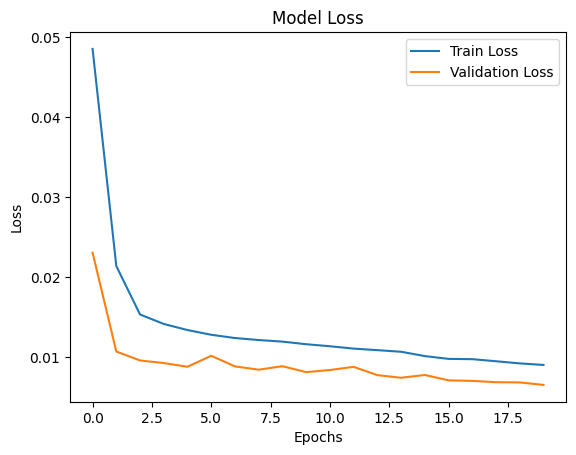

In [60]:
# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [61]:
model.save('lstm_traffic_volume_model.h5')

In [62]:
model.save('my_model.keras')

In [63]:
#Compile the model with the desired metrics
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [64]:
# Check the shapes of X_test and y_test
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

# If there's a mismatch, align the number of samples
if X_test.shape[0] != y_test.shape[0]:
    min_samples = min(X_test.shape[0], y_test.shape[0])
    X_test = X_test[:min_samples]
    y_test = y_test[:min_samples]
    print(f"Aligned X_test shape: {X_test.shape}")
    print(f"Aligned y_test shape: {y_test.shape}")

# Recompile the model if needed
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Now evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")


Shape of X_test: (2356, 1, 10)
Shape of y_test: (2354,)
Aligned X_test shape: (2354, 1, 10)
Aligned y_test shape: (2354,)
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0384 - mae: 0.1452
Test Loss: 0.040464624762535095
Test MAE: 0.14778777956962585


In [48]:
# Make predictions
predictions = model.predict(X_test)
# Extract only the traffic_volume column from the scaled test set
# We'll build dummy arrays with 10 columns so inverse_transform works properly

import numpy as np

# Create dummy arrays with same shape as the original features
predicted_full = np.zeros((len(predictions), len(features)))
actual_full = np.zeros((len(y_test), len(features)))

# Set only the first column (traffic_volume) to our predicted and true values
predicted_full[:, 0] = predictions.flatten()
actual_full[:, 0] = y_test.flatten()

# Now inverse transform both
predicted_traffic = scaler.inverse_transform(predicted_full)[:, 0]
actual_traffic = scaler.inverse_transform(actual_full)[:, 0]


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


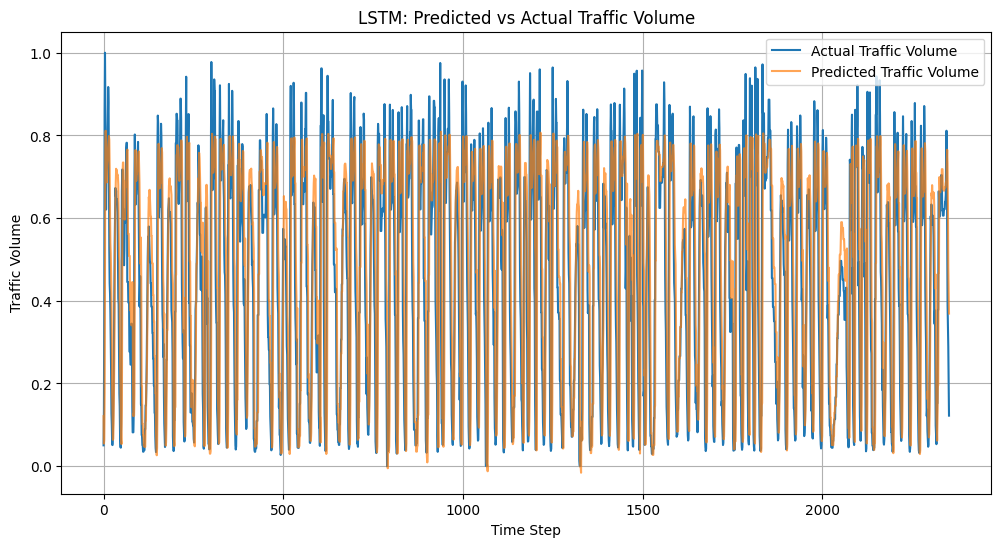

In [65]:
# Assuming `y_test` contains the actual values and `predictions` contains the predicted values
# For example, the predictions might be the output of model.predict(X_test)
actual_traffic = y_test
predicted_traffic = model.predict(X_test)

# Plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual_traffic, label='Actual Traffic Volume')
plt.plot(predicted_traffic, label='Predicted Traffic Volume', alpha=0.7)
plt.title('LSTM: Predicted vs Actual Traffic Volume')
plt.xlabel('Time Step')
plt.ylabel('Traffic Volume')
plt.legend()
plt.grid(True)
plt.show()


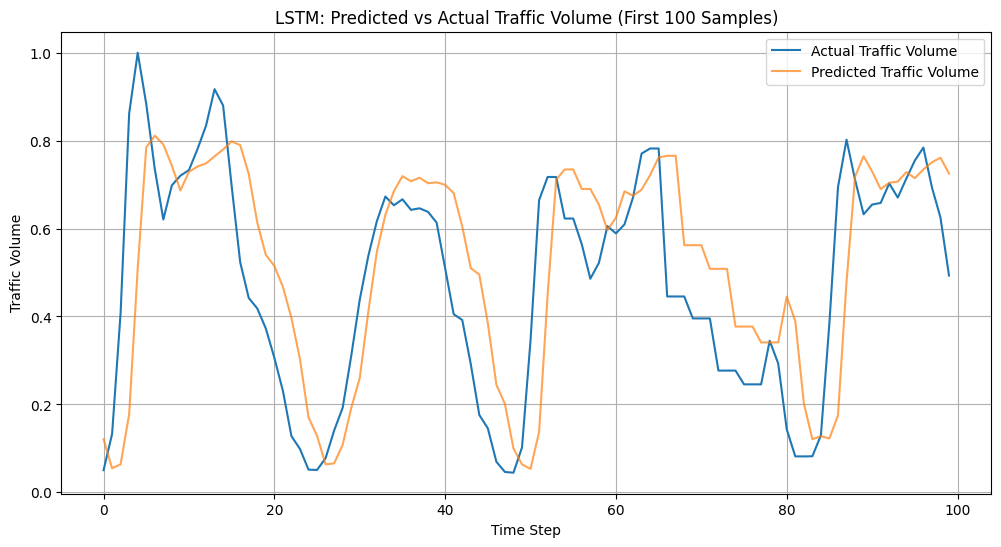

In [66]:
import matplotlib.pyplot as plt

# Plot only the first 100 values
plt.figure(figsize=(12, 6))
plt.plot(actual_traffic[:100], label='Actual Traffic Volume')
plt.plot(predicted_traffic[:100], label='Predicted Traffic Volume', alpha=0.7)
plt.title('LSTM: Predicted vs Actual Traffic Volume (First 100 Samples)')
plt.xlabel('Time Step')
plt.ylabel('Traffic Volume')
plt.legend()
plt.grid(True)
plt.show()


In [69]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate error metrics
mae = mean_absolute_error(actual_traffic, predicted_traffic)
mse = mean_squared_error(actual_traffic, predicted_traffic)
rmse = np.sqrt(mse)

print(f" Mean Absolute Error (MAE): {mae:.2f}")
print(f" Mean Squared Error (MSE): {mse:.2f}")
print(f" Root Mean Squared Error (RMSE): {rmse:.2f}")


 Mean Absolute Error (MAE): 0.15
 Mean Squared Error (MSE): 0.04
 Root Mean Squared Error (RMSE): 0.20


In [67]:
# Save the model in HDF5 format
model.save('traffic_forecast_model.h5')

# Alternatively, you can save in the newer Keras format (recommended)
# model.save('traffic_forecast_model.keras')

In [70]:
# Assuming 'lstm_model' is your trained LSTM model
# Save the model in the 'models/' folder
model.save('models/traffic_forecast_model.h5')
